# Example

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from load_data import get_projections_spacing_radius
from psf_fit import get_psf_kernel
from ipywidgets import interact, widgets
import dill as pickle
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Before running the python code for analysis, you will need to generate PSF data to fit using SIMIND. The `simind.smc` file is the default one I leave here. I generate my own data by running the commands:

`simind 440keV_r35/53:1/59:1/01:440/26:500/12:35`

Note that index 01 changes the energy (`01:440`) and index 12 changes the radius (`12:35`). I use these numbers when generating the filename (`440kev_r35`). As can be seen below, I ran 6 SIMIND simulations corresponding to 6 different radii.

Open data:

In [105]:
ds = [10,15,20,25,30,35,40,45,50,55]
paths = [f'440kev_r{d}' for d in ds]

Get PSF kernel:
* What is returned is a function which takes in 3 arguments: x positions, y positions, and distance from the detector.

In [106]:
kernel_f = get_psf_kernel(paths[::2])

c:\Users\lukep\Code\simind_psf_modeling\fit_functions.py:6: RuntimeWarning: overflow encountered in exp
  return b1*np.exp(-b2*d)+b3*np.exp(-b4*d)
c:\Users\lukep\Code\simind_psf_modeling\fit_functions.py:6: RuntimeWarning: overflow encountered in multiply
  return b1*np.exp(-b2*d)+b3*np.exp(-b4*d)
c:\Users\lukep\Code\simind_psf_modeling\fit_functions.py:9: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(b1*d**2+b2)+b3
c:\Users\lukep\anaconda3\envs\pytorch\lib\site-packages\scipy\integrate\_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r

Save kernel:

In [107]:
with open('psf_kernel.pkl', 'wb') as f:
    pickle.dump(kernel_f, f)

Open kernel

In [115]:
with open('psf_kernel.pkl', 'rb') as f:
    kernel_f = pickle.load(f)

Lets make sure the kernel is properly normalized:

In [116]:
Nx = 125
dx = 0.8
x_eval = y_eval = np.arange(-(Nx-1)/2, (Nx+1)/2, 1) * dx
ks = [kernel_f(x_eval, y_eval, d=d, normalize=True) for d in [25,35,45]]

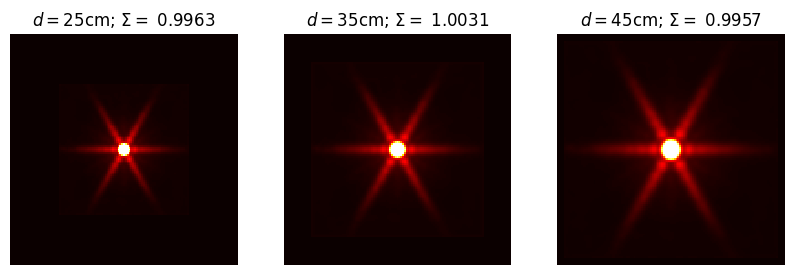

In [110]:
plt.subplots(1,3,figsize=(10,3))
plt.subplot(131)
plt.pcolormesh(ks[0], cmap='hot', vmax=ks[0].max()/10)
plt.title(f'$d=25$cm; $\Sigma =$ {ks[0].sum():.4f}')
plt.axis('off')
plt.subplot(132)
plt.pcolormesh(ks[1], cmap='hot', vmax=ks[1].max()/10)
plt.title(f'$d=35$cm; $\Sigma =$ {ks[1].sum():.4f}')
plt.axis('off')
plt.subplot(133)
plt.pcolormesh(ks[2], cmap='hot', vmax=ks[2].max()/10)
plt.title(f'$d=45$cm; $\Sigma =$ {ks[2].sum():.4f}')
plt.axis('off')
plt.show()

Note: The fact that the larger distances don't sum to 1 is *as intended*: since the tails are cut off, only a portion of the PSF is shown. This is required for proper modeling in the system matrix (the photons outside the tails are "ignored", but its better than overpredicting in the center)

Now lets validate with the data:

In [111]:
# Spacing of the theoretical kernel
Nx = 255
dx = 0.12
x_eval = y_eval = np.arange(-(Nx-1)/2, (Nx+1)/2, 1) * dx
projectionss_data = []
projectionss_analytical = []
for path in paths:
    projections_data, dr, distance = get_projections_spacing_radius(path)
    projections_analytical = kernel_f(x_eval, y_eval, d=distance, normalize=False)
    projectionss_data.append(projections_data)
    projectionss_analytical.append(projections_analytical)

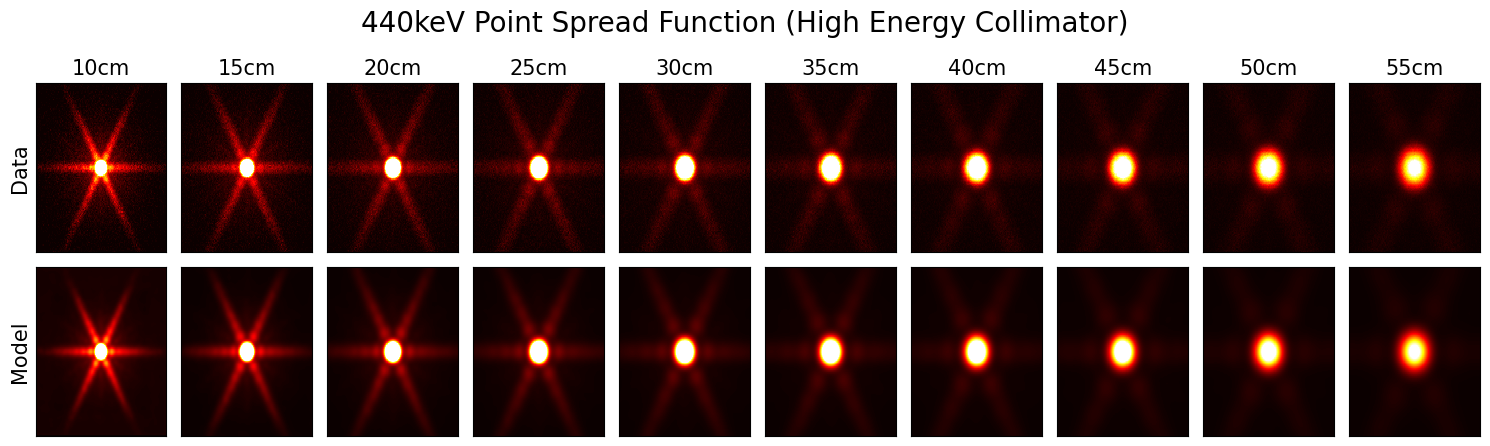

In [112]:
def plot(projections, ax):
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    return ax.pcolormesh(projections, cmap='hot', vmax=0.05)

fig, axes = plt.subplots(2,10,figsize=(15, 4.5))
for i, ax in enumerate(axes[0]):
    C = plot(projectionss_data[i], ax)
for i, ax in enumerate(axes[1]):
    C = plot(projectionss_analytical[i], ax,)
for i, ax in enumerate(axes[0]):
    ax.set_title(f'{ds[i]}cm', fontsize=15)
axes[0,0].set_ylabel('Data', fontsize=15)
axes[1,0].set_ylabel('Model', fontsize=15)
fig.suptitle('440keV Point Spread Function (High Energy Collimator)', fontsize=20)
fig.tight_layout()
plt.savefig('im.png', dpi=300)

Create an interactive plot

In [113]:
4/3 * np.pi * 3**3

113.09733552923254

In [101]:
def plot_function(parameter):
    x_eval = y_eval = np.arange(-(Nx-1)/2, (Nx+1)/2, 1) * dx
    z_eval = kernel_f(x_eval, y_eval, d=parameter)
    plt.figure(figsize=(5, 5.5))
    plt.pcolormesh(z_eval, cmap='hot', vmax=0.0001)
    plt.axis('off')
    plt.show()
    
parameter_slider = widgets.FloatSlider(
    value=25,  # Initial value of the parameter
    min=10,    # Minimum value
    max=40,    # Maximum value
    step=0.1,   # Step size
    description='R [cm]:',
)

interact(plot_function, parameter=parameter_slider)

interactive(children=(FloatSlider(value=25.0, description='R [cm]:', max=40.0, min=10.0), Output()), _dom_clas…

<function __main__.plot_function(parameter)>